In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("datasets/Creditscore/train.csv")


C:\Users\panch\AppData\Local\Temp\ipykernel_17932\1157329845.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datasets/Creditscore/train.csv")


In [2]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [3]:
df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [4]:
df.describe(include='object')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,100000,100000,100000,100000,100000,88592,92998,100000,100000,100000,90970,100000,95521,100000,98800,100000
unique,100000,12500,8,10139,1788,12501,16,18940,434,6260,749,4384,4,13178,404,3,91049,7,98792,3
top,0x1602,CUS_0xd40,January,Langep,38,#F%$D@*&8,_______,36585.12,3,Not Specified,19,_,Standard,1360.45,15 Years and 11 Months,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12500,44,2833,5572,7062,16,14386,1408,5327,2091,36479,24,446,52326,4305,25513,9,53174


Dropping unnecessery features.

In [5]:
df.drop(["Customer_ID","Month","Name","ID","Payment_of_Min_Amount"],1,inplace = True)

Labeling Catagorical Data.

In [6]:
occupationEn = LabelEncoder()
df["Occupation"] = occupationEn.fit_transform(df["Occupation"])

payBehEn = LabelEncoder()
df["Payment_Behaviour"] = payBehEn.fit_transform(df["Payment_Behaviour"])

CreditMixEn = LabelEncoder()
df["Credit_Mix"] = CreditMixEn.fit_transform(df["Credit_Mix"])

df["Occupation"] = df["Occupation"].fillna("_______")
OccupationEn = LabelEncoder()
df["Occupation"] = OccupationEn.fit_transform(df["Occupation"])

CreditScoreEn = LabelEncoder()
df["Credit_Score"] = CreditScoreEn.fit_transform(df["Credit_Score"])

Dealing with Garbage values in SSN.

In [7]:
df.drop(df[df["SSN"] == "#F%$D@*&8"].index,inplace = True)
df["SSN"] = df["SSN"].str.replace("-","").astype(int)
df["SSN"].dtypes

dtype('int32')

Converting Credit_History_Age values of N years and M mounts into numercial value.

In [8]:
def ageToNum(age):
    if age:
        age = list(map(int,re.findall(r'\d+',age)))
        return age[0] + (age[1]/10)
    else:
        return age

In [9]:
df["Credit_History_Age"] = df["Credit_History_Age"].fillna(0).apply(ageToNum).astype(float)

In [10]:
df["Credit_History_Age"].head()

0    22.1
1     0.0
2    22.3
3    22.4
4    22.5
Name: Credit_History_Age, dtype: float64

Creating one-hot encoding for sublist of Type of Loans Column.

In [11]:
df["Type_of_Loan"] = df["Type_of_Loan"].fillna("No loans").str.replace("and","").str.replace(r",\s*",",").str.split(",")

loanSet = set()

[loanSet.add(j) for i in df["Type_of_Loan"] for j in i ]
loanSet = list(map(str.lower,loanSet))
loanSet.sort()

    
def loans(loans):
    res = {
        'auto loan': 0,
        'credit-builder loan': 0 ,
        'debt consolidation loan' : 0,
        'home equity loan' : 0,
        'mortgage loan' : 0,
        'no loans' : 0,
        'not specified' : 0,
        'payday loan' : 0,
        'personal loan' : 0,
        'student loan' : 0
    }
    for loan, i in zip(loans,range(9)):
        if loan.lower() in loanSet:

            res[loan.lower()] = 1
    return res

In [12]:
df = pd.concat([df, pd.json_normalize(df["Type_of_Loan"].apply(loans))], axis=1)
df.drop("Type_of_Loan",1,inplace = True)

In [13]:
df.head()

,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,auto loan,credit-builder loan,debt consolidation loan,home equity loan,mortgage loan,no loans,not specified,payday loan,personal loan,student loan
0,23,821000265.0,12.0,19114.12,1824.843333,3.0,4.0,3.0,4,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,23,821000265.0,12.0,19114.12,NaN,3.0,4.0,3.0,4,-1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-500,821000265.0,12.0,19114.12,NaN,3.0,4.0,3.0,4,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,23,821000265.0,12.0,19114.12,NaN,3.0,4.0,3.0,4,5.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,23,821000265.0,12.0,19114.12,1824.843333,3.0,4.0,3.0,4,6.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Dealing with outliers.

In [14]:
df.drop(df[df["Interest_Rate"] > 30].index,inplace = True)

In [15]:
df["Age"] = df["Age"].str.extract('(\d+)').astype(float)



In [16]:
df["Age"].describe()

count    86698.000000
mean       119.368624
std        682.597891
min         14.000000
25%         25.000000
50%         34.000000
75%         43.000000
max       8698.000000
Name: Age, dtype: float64

Dealing wtih missing values.

In [17]:

df["Monthly_Inhand_Salary"].fillna(0.0, inplace=True)

df["Changed_Credit_Limit"] = df["Changed_Credit_Limit"].replace("_",0)


for i in df.columns:
    if df[i].dtype == object:
        print(i)
        df[i] = df[i].str.replace("_","").replace("",0).astype(float)

ageMean = df[(df["Age"] > 0) & (df["Age"] < 100)]["Age"].mean()
df["Age"].fillna(ageMean)

df.loc[(df["Age"] < 0) | (df["Age"] > 100),"Age"] = ageMean

df.drop(df[df["Credit_Score"].isna()].index,inplace = True)
df.drop(df[df["Changed_Credit_Limit"].isna()].index,inplace = True)


fillz = loanSet + ["Monthly_Balance" , "Amount_invested_monthly", "Num_Credit_Inquiries" , "Num_of_Delayed_Payment"]
for typ in fillz:
    df[typ].fillna(0,inplace = True)



Annual_Income
Num_of_Loan
Num_of_Delayed_Payment
Changed_Credit_Limit
Outstanding_Debt
Amount_invested_monthly
Monthly_Balance


In [18]:
df.isnull().sum()

Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
auto loan                   0
credit-builder loan         0
debt consolidation loan     0
home equity loan            0
mortgage loan               0
no loans                    0
not specified               0
payday loan                 0
personal loan               0
student loan                0
dtype: int64

Dealing with outliers

In [19]:
df.columns

Index(['Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'auto loan', 'credit-builder loan',
       'debt consolidation loan', 'home equity loan', 'mortgage loan',
       'no loans', 'not specified', 'payday loan', 'personal loan',
       'student loan'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

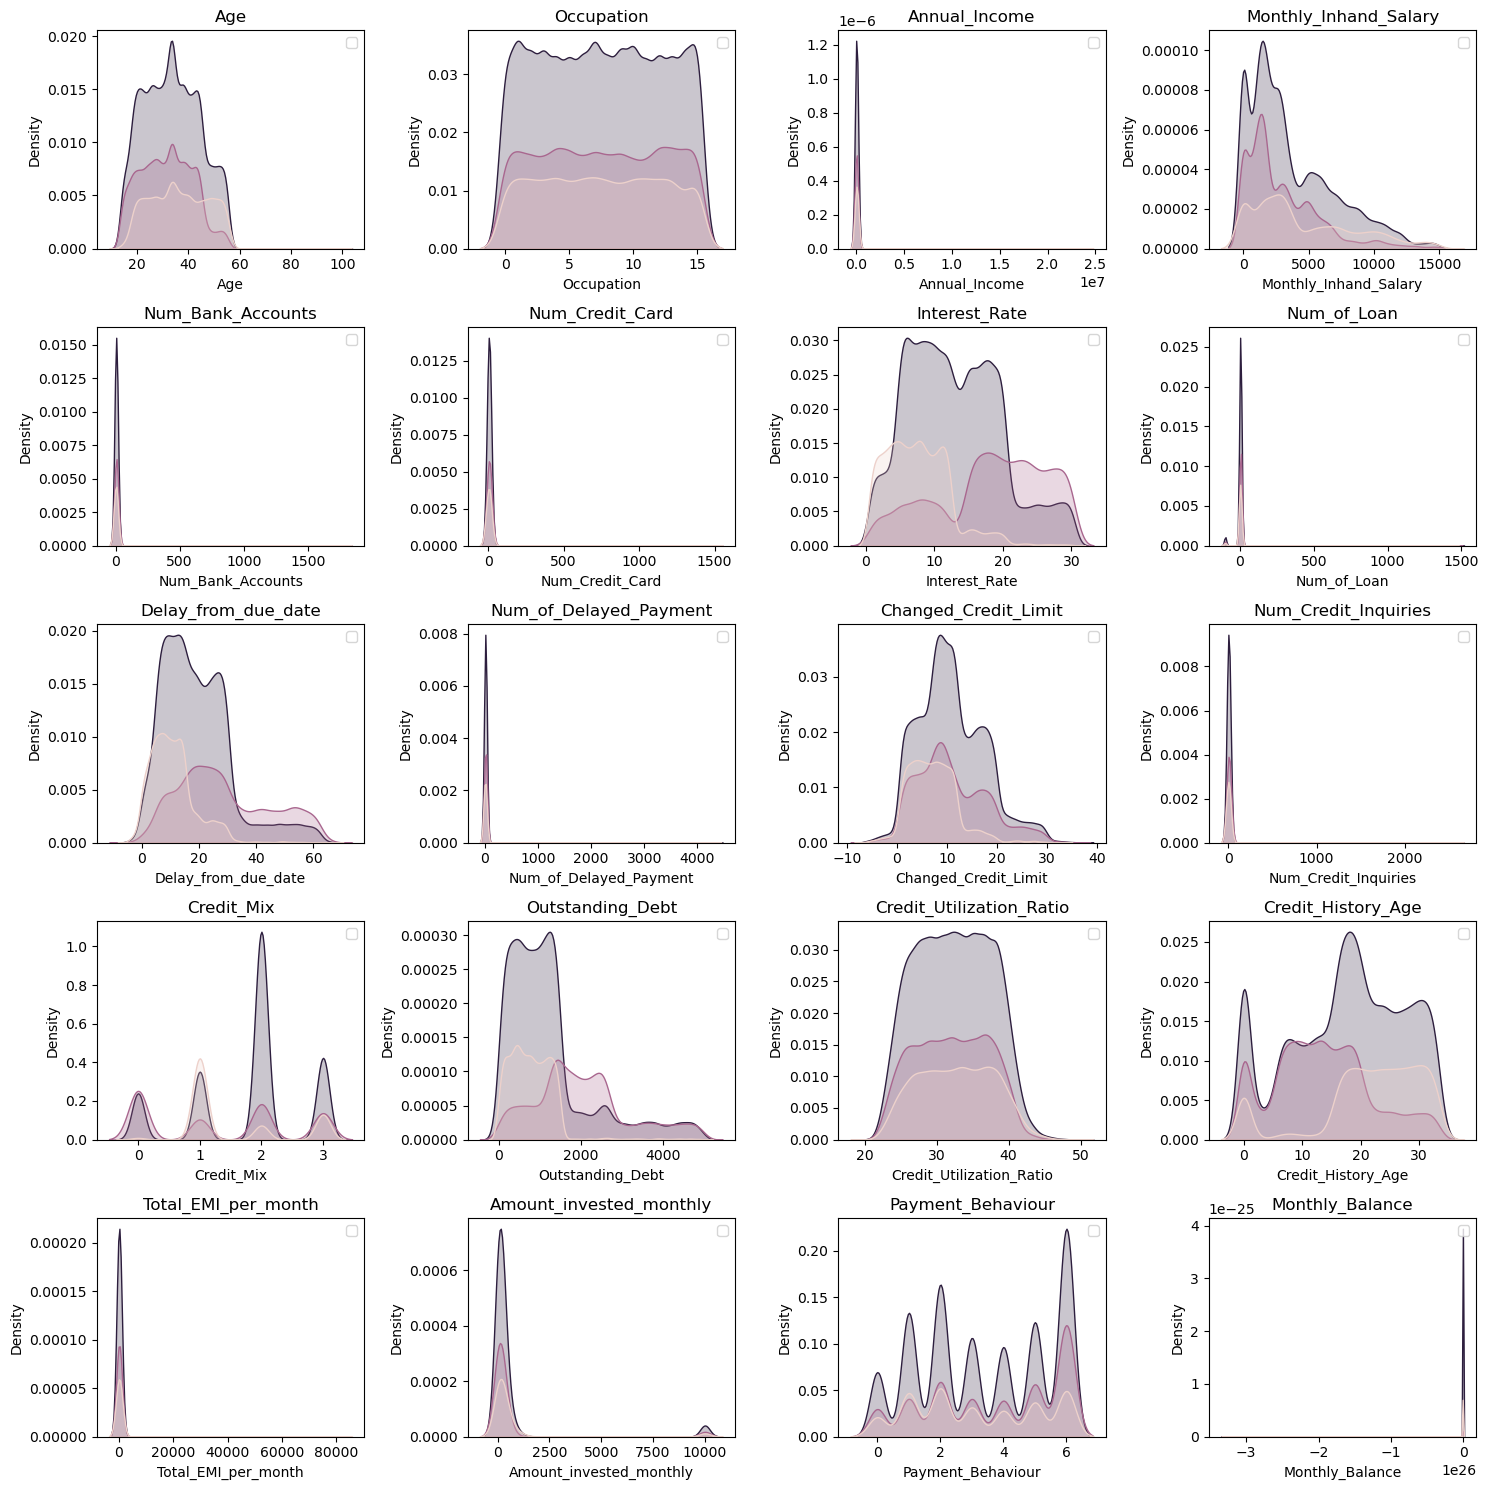

In [20]:
num_cols = ["Age","Occupation","Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts","Num_Credit_Card","Interest_Rate","Num_of_Loan",\
           "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit","Num_Credit_Inquiries","Credit_Mix","Outstanding_Debt",\
           "Credit_Utilization_Ratio","Credit_History_Age","Total_EMI_per_month","Amount_invested_monthly","Payment_Behaviour",\
           "Monthly_Balance"]

plt.figure(figsize=(15,15))
for ax, col in enumerate(num_cols):

    plt.subplot(5,4, ax+1)
    plt.title(col)
    sns.kdeplot(x=df[col],shade=True, hue=df["Credit_Score"])
    plt.legend()

plt.tight_layout()

In [22]:
def IQR(series):
    Q3 = series.quantile(0.75)
    Q1 = series.quantile(0.25)
    IQR = Q3 - Q1
    upper_limit = series.quantile(0.75) + (IQR * 1.5)
    lower_limit = series.quantile(0.25) - (IQR * 1.5)
    return lower_limit,upper_limit

def replace_outliers(series):
    lower,upper = IQR(series)
    series = np.where(series > upper,upper,np.where(series<lower,lower,series))
    return series


In [23]:
outlierCols = ["Annual_Income","Num_Bank_Accounts","Num_Credit_Card","Num_of_Loan","Num_of_Delayed_Payment","Num_Credit_Inquiries",\
              "Total_EMI_per_month","Monthly_Balance","Amount_invested_monthly"]

for col in outlierCols:
    df[col] = np.where(df[col]<0,0,df[col])
    df[col] = replace_outliers(df[col])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

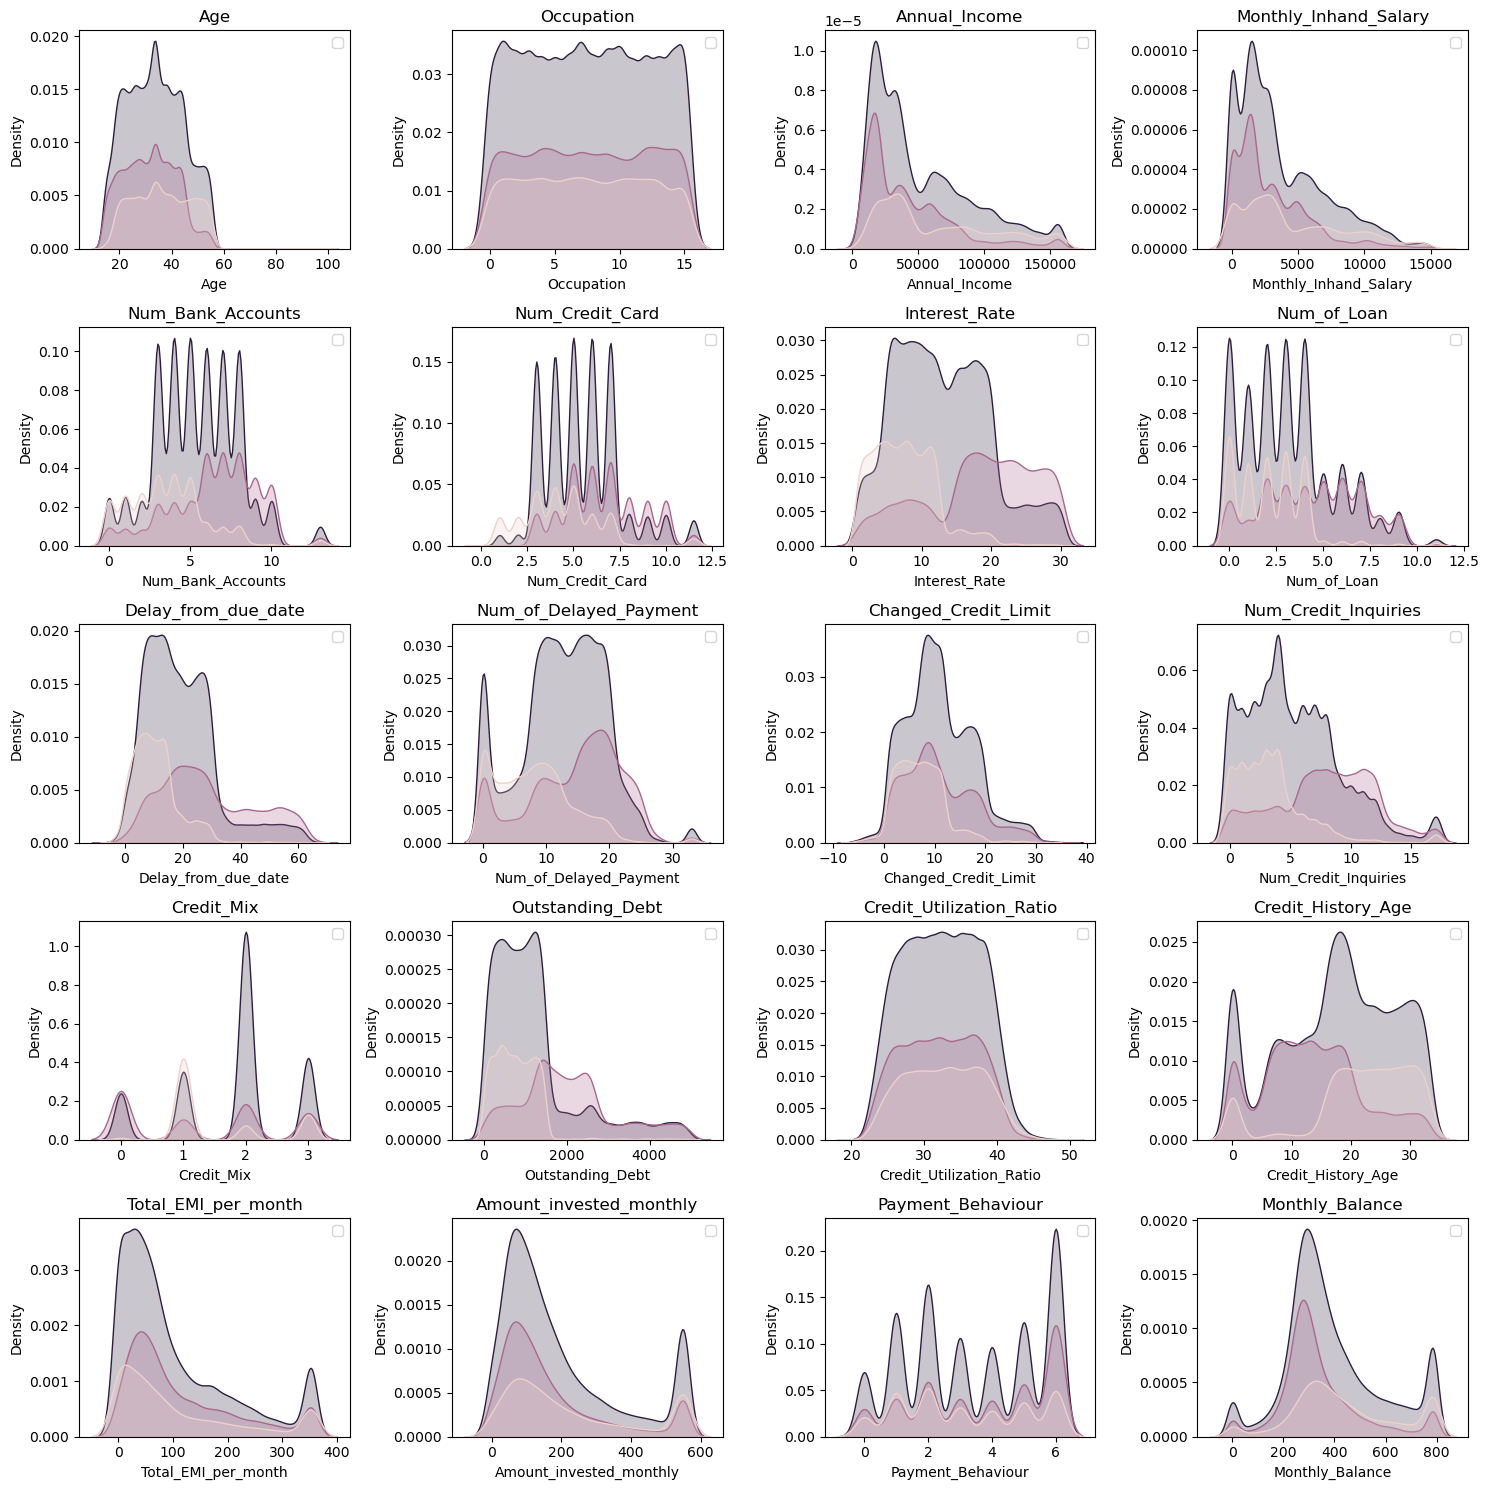

In [24]:
num_cols = ["Age","Occupation","Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts","Num_Credit_Card","Interest_Rate","Num_of_Loan",\
           "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit","Num_Credit_Inquiries","Credit_Mix","Outstanding_Debt",\
           "Credit_Utilization_Ratio","Credit_History_Age","Total_EMI_per_month","Amount_invested_monthly","Payment_Behaviour",\
           "Monthly_Balance"]

plt.figure(figsize=(15,15))
for ax, col in enumerate(num_cols):

    plt.subplot(5,4, ax+1)
    plt.title(col)
    sns.kdeplot(x=df[col],shade=True, hue=df["Credit_Score"])
    plt.legend()

plt.tight_layout()

Density graph of labels.

<Axes: xlabel='Credit_Score', ylabel='Density'>

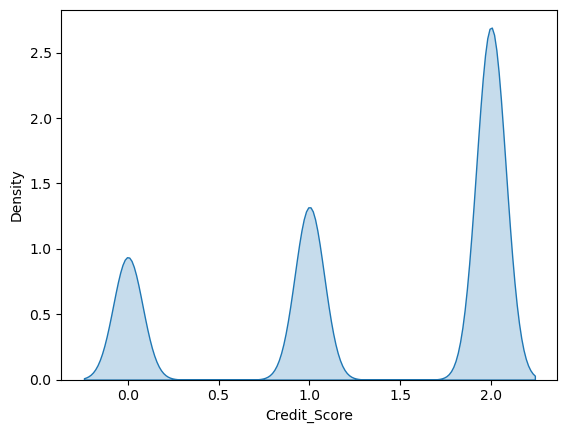

In [25]:
sns.kdeplot(df["Credit_Score"],shade = True)

Trying Different Classification Models.

In [26]:
X = df.drop("Credit_Score",1)
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)


Score: 0.5461577728040209


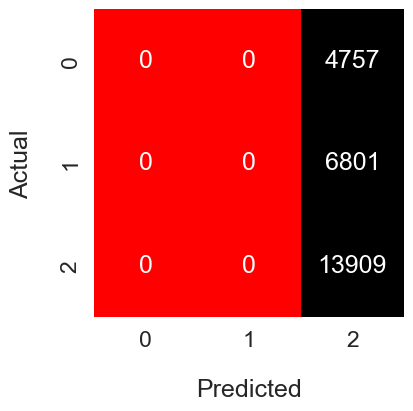

In [27]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)
print("Score:",clf.score(X_test,y_test))
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

Random Forest

Score:  0.7540738995562886


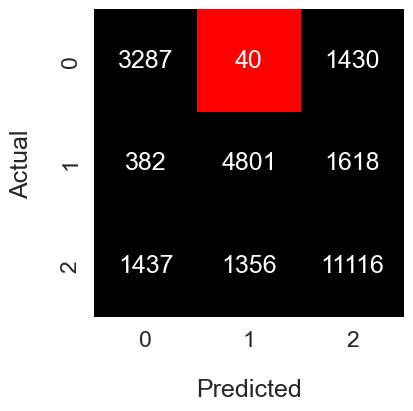

In [28]:
# params = {"n_estimators": [50,100,300],
#          "max_depth":[7,10,15],
#           "min_samples_split":[2,4,6],
#          }

# random_f = RandomForestClassifier()
# random_f_cv =  GridSearchCV(random_f,params,cv = 3,n_jobs = -1, verbose = 2).fit(X_train,y_train)

params = {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=params["n_estimators"],max_depth=params["max_depth"],\
                             min_samples_split = params["min_samples_split"], n_jobs = -1)
clf = clf.fit(X_train,y_train)
print("Score: ",clf.score(X_test,y_test))
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

Decision Tree Classifier

Score: 0.7044803078493737


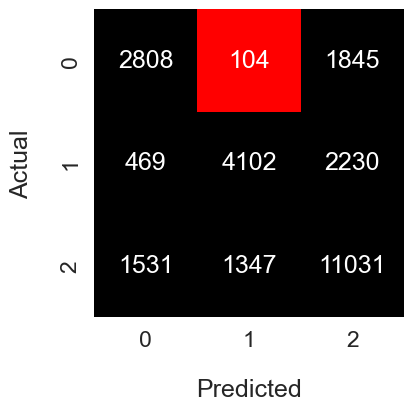

In [29]:
# params = {"max_depth":[7,10,15],
#           "criterion" :["gini","entropy","log_loss"],
#           "min_samples_split":[2,4,6],
#          }

# dt = DecisionTreeClassifier()
# dt_cv =  GridSearchCV(dt,params,cv = 3,n_jobs = -1, verbose = 2).fit(X_train,y_train)
params = {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion=params["criterion"],max_depth = params["max_depth"],\
                             min_samples_split=params["min_samples_split"], random_state = 1)
clf.fit(X_train,y_train)
print("Score:",clf.score(X_test,y_test))
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

XG Boost

Score: 0.7926336042721954


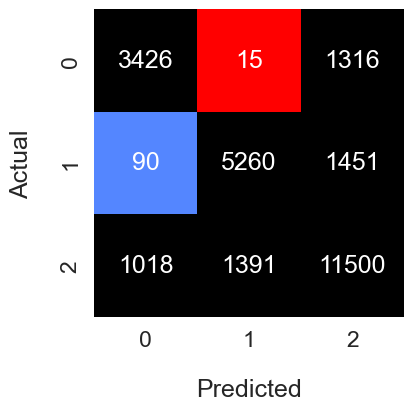

In [30]:
# from sklearn.model_selection import GridSearchCV
# params = {"n_estimators": [50,100,300],
#          "subsample":[0.5,0.8,1],
#          "max_depth":[5,10,15],
#          "learning_rate": [0.1,0.01,0.3]}




# xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
# xgb_cv = GridSearchCV(xgb_model,params,cv = 3,n_jobs = -1, verbose = 2).fit(X_train,y_train)

params = {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'subsample': 0.8}

import xgboost as xgb


xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42,\
                              learning_rate = params["learning_rate"],\
                              max_depth = params["max_depth"],\
                             n_estimators = params["n_estimators"],
                             subsample = params["subsample"])
xgb_model.fit(X_train, y_train)
print("Score:",xgb_model.score(X_test,y_test))
y_pred = xgb_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()